Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Modular Patch Inference

In [1]:
import os

import torch
from matplotlib import pyplot as plt
from monai.inferers import AvgMerger, PatchInferer, SlidingWindowSplitter, WSISlidingWindowSplitter
from monai.data import Dataset, DataLoader, PILReader
from monai.transforms import LoadImage, Compose, EnsureChannelFirst, AsChannelLast
from tests.utils import download_url_or_skip_test, testing_data_config

/Users/bhashemian/workspace/project-monai/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Auxiliary functions

In [2]:
def plot_limit_axis(ax, img, xlim, ylim):
    ax.imshow(AsChannelLast()(img[0]).to(torch.uint8))
    ax.set_xlim([0, xlim])
    ax.set_ylim([ylim, 0])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

def network_random_brightness(img):
    return img * (torch.rand(1) + 1) * 0.5


def run_inference(inferer, network, filenames, transform=None):
    dataset = Dataset(filenames, transform=transform)
    outputs = []
    for inputs in DataLoader(dataset):
        out = inferer(inputs, network)
        outputs.append(out)
    return outputs

## Sliding Window Patch Inference
Inference of images by splitting them into patches using sliding window and merging the patches to build the inference result for the entire image.

In [3]:
# Plot aux function
def cat_plot(ax, img):
    plot_limit_axis(ax, img, 512, 640)

# Download the image and create file path list
IMAGE_URLS = ["https://github.com/Project-MONAI/MONAI/raw/dev/tests/testing_data/kitty_test.jpg"]
IMAGE_PATH_LIST = []
for url in IMAGE_URLS:
    path = os.path.join(os.path.abspath("."), os.path.basename(url))
    download_url_or_skip_test(url, path)
    IMAGE_PATH_LIST.append(path)

# Transforms
transforms = Compose([LoadImage(reader=PILReader, reverse_indexing=False, image_only=True), EnsureChannelFirst()])

# Load input image (for plotting purposes only)
IMAGE = transforms(IMAGE_PATH_LIST)

kitty_test.jpg: 64.0kB [00:02, 30.9kB/s]                            

2023-05-30 11:30:51,067 - INFO - Downloaded: /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/kitty_test.jpg
2023-05-30 11:30:51,068 - INFO - Expected md5 is None, skip md5 check for file /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/kitty_test.jpg.


## Effect of overlap

Text(0.5, 0.98, 'Effect of overlap (without padding, patch_size=64)')

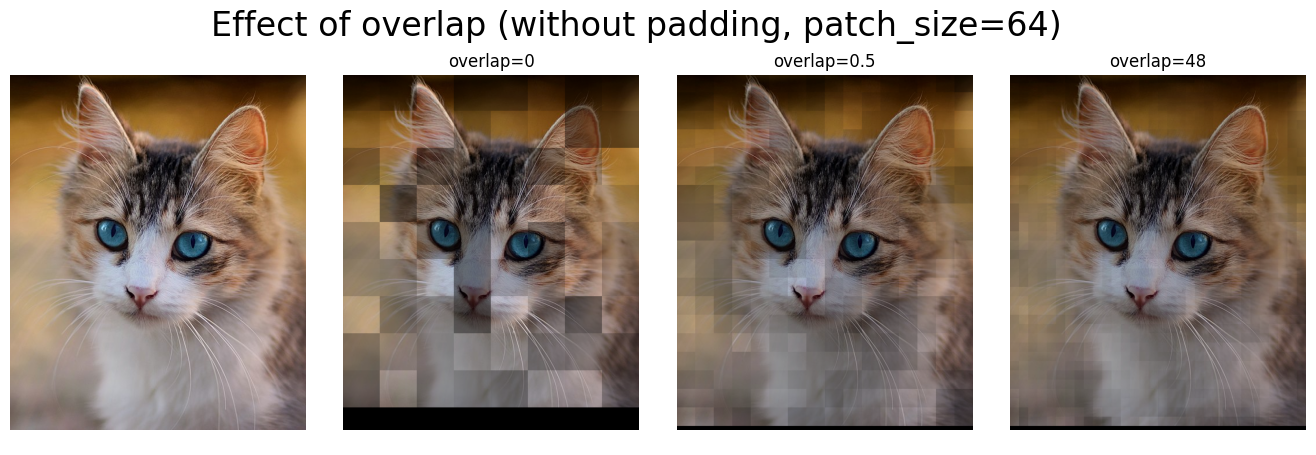

In [4]:
patch_size = 64
overlaps = [0, 0.5, 48]
nrows = 1
ncols = len(overlaps) + 1
figsize = (4 * ncols + 1, 5 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
cat_plot(axes[0], IMAGE)
for i, overlap in enumerate(overlaps, 1):
    inferer = PatchInferer(
        splitter=SlidingWindowSplitter(patch_size=patch_size, overlap=overlap, pad_mode=None),
        merger_cls=AvgMerger,
        match_spatial_shape=False,
    )
    img = run_inference(inferer, network_random_brightness, IMAGE_PATH_LIST, transforms)
    cat_plot(axes[i], img[0])
    axes[i].set_title(f"{overlap=}", fontsize=12)

fig.suptitle(f"Effect of overlap (without padding, {patch_size=})", fontsize=24)

## Effect of padding and matching spatial shape

Text(0.5, 0.98, ' Effect of padding and matching spatial shape (without overlap, patch_size=64)')

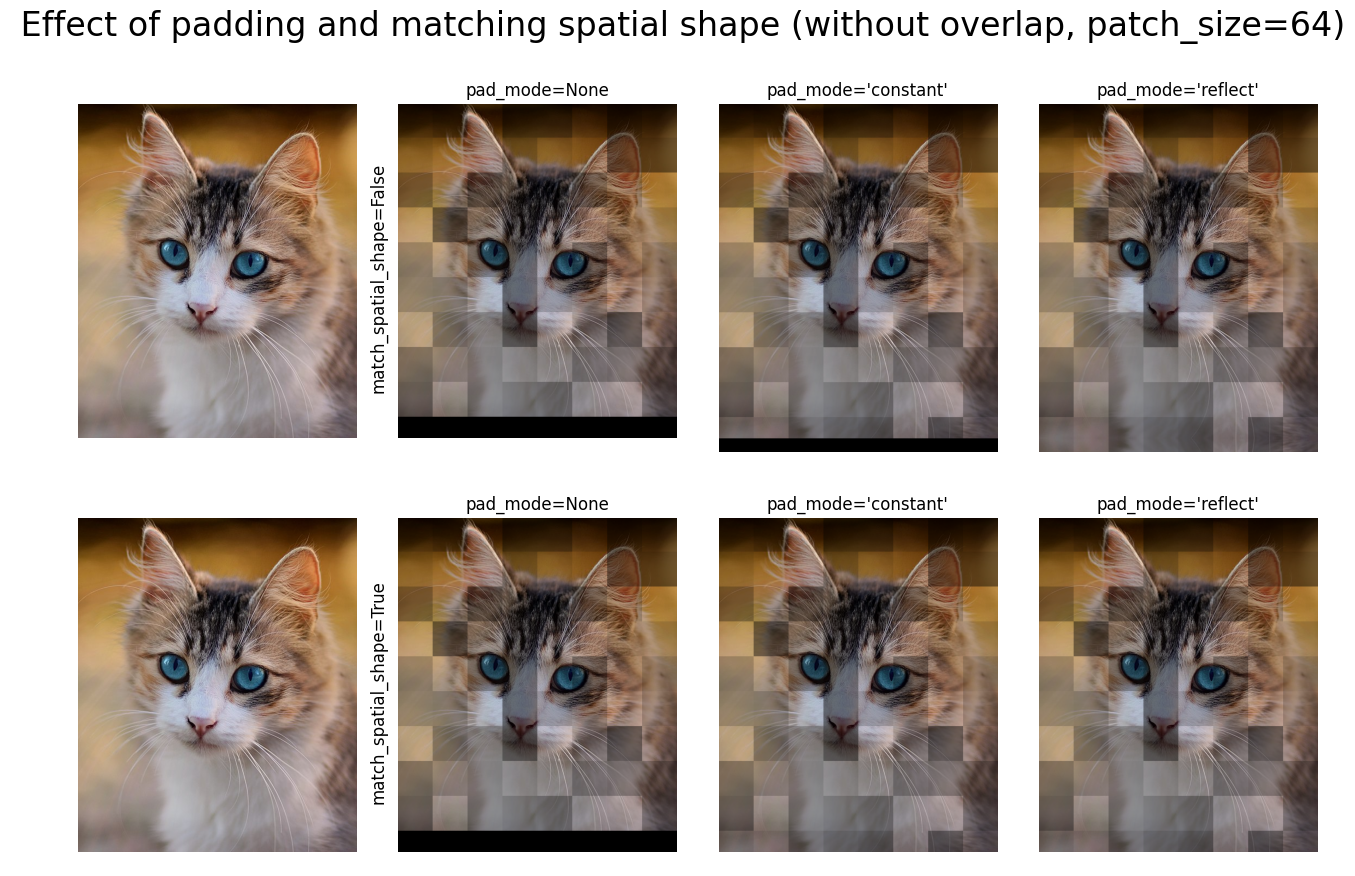

In [5]:
match_spatial_shapes = [False, True]
pad_modes = [None, "constant", "reflect"]
nrows = len(match_spatial_shapes)
ncols = len(pad_modes) + 1
figsize = (4 * ncols, 5 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.15, hspace=0.1, top=0.9)
cat_plot(axes[0, 0], IMAGE)
cat_plot(axes[1, 0], IMAGE)
for i, match_spatial_shape in enumerate(match_spatial_shapes):
    for j, pad_mode in enumerate(pad_modes, 1):
        inferer = PatchInferer(
            splitter=SlidingWindowSplitter(patch_size=patch_size, pad_mode=pad_mode),
            merger_cls=AvgMerger,
            match_spatial_shape=match_spatial_shape,
        )
        img = run_inference(inferer, network_random_brightness, IMAGE_PATH_LIST, transforms)
        ax = axes[i, j]
        cat_plot(ax, img[0])
        ax.set_title(f"{pad_mode=}", fontsize=12)
        if j == 1:
            ax.set_ylabel(f"{match_spatial_shape=}", fontsize=12)
fig.suptitle(f" Effect of padding and matching spatial shape (without overlap, {patch_size=})", fontsize=24)

## WSI Sliding Window Patch Inference
Inference of whole slide images by splitting them into patches using sliding window (without loading the entire image into memory and merging) the patches to build the inference result for the entire image.

In [6]:
# Plot aux function
def wsi_plot(ax, img):
    plot_limit_axis(ax, img, 800, 600)


# Download whole slide images and create file path list
WSI_KEYS = ["wsi_generic_tiff"]
WSI_PATH_LIST = []
for key in WSI_KEYS:
    path = os.path.join(os.path.abspath("."), f"temp_{key}.tiff")
    download_url_or_skip_test(
        testing_data_config("images", key, "url"),
        path,
        hash_type=testing_data_config("images", key, "hash_type"),
        hash_val=testing_data_config("images", key, "hash_val"),
    )
    WSI_PATH_LIST.append(path)

# The level at which image should be loaded
WSI_LEVEL = 6

temp_wsi_generic_tiff.tiff: 195MB [09:15, 368kB/s]                                

2023-05-30 11:40:08,722 - INFO - Downloaded: /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/temp_wsi_generic_tiff.tiff


2023-05-30 11:40:09,283 - INFO - Verified 'temp_wsi_generic_tiff.tiff', sha256: 73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd.


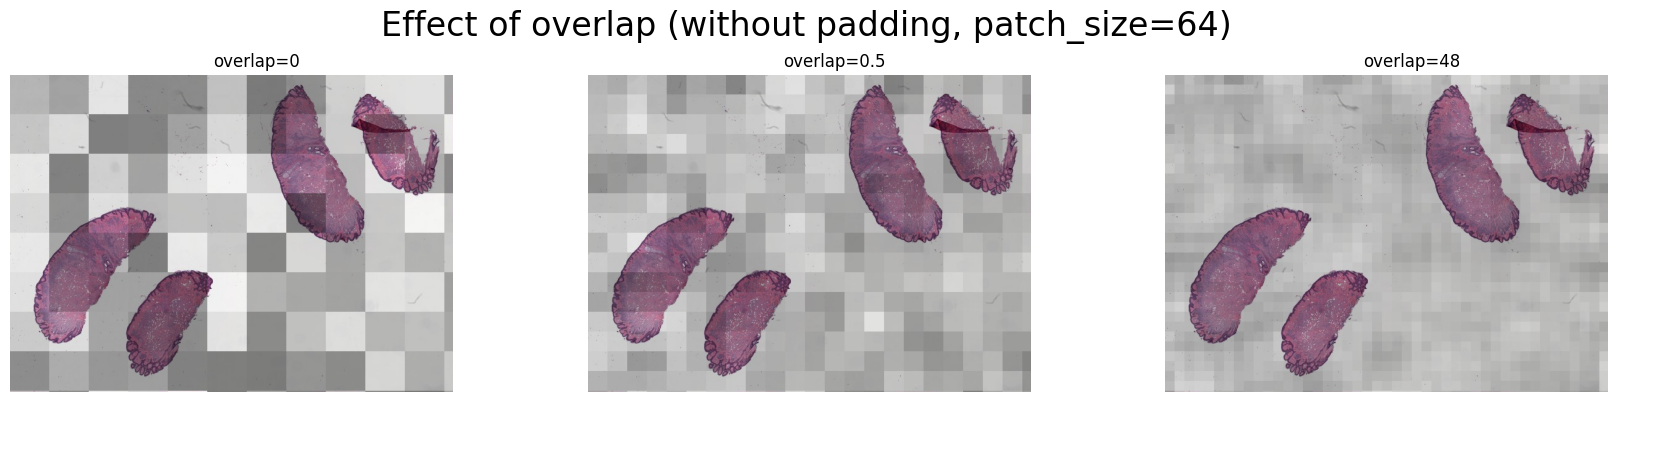

In [7]:
patch_size = 64
overlaps = [0, 0.5, 48]
nrows = 1
ncols = len(overlaps)
figsize = (7 * ncols + 1, 5 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
for i, overlap in enumerate(overlaps):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(
            patch_size=patch_size,
            overlap=overlap,
            reader="OpenSlide",
            level=WSI_LEVEL,
        ),
        merger_cls=AvgMerger,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"{overlap=}", fontsize=12)

fig.suptitle(f"Effect of overlap (without padding, {patch_size=})", fontsize=24);

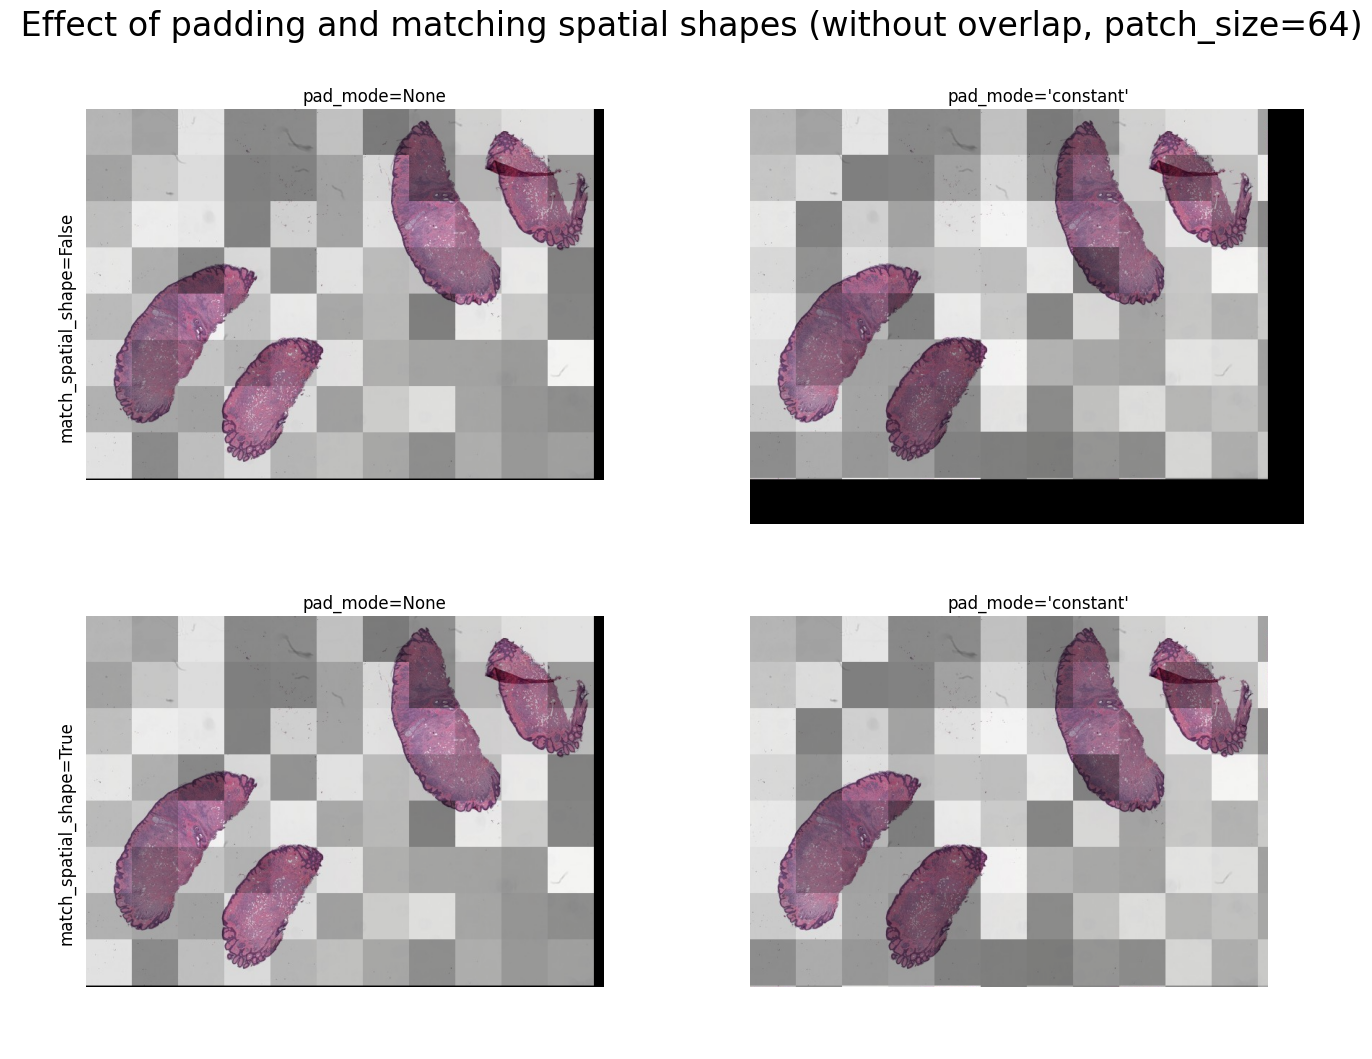

In [8]:
match_spatial_shapes = [False, True]
pad_modes = [None, "constant"]
nrows = len(match_spatial_shapes)
ncols = len(pad_modes)
figsize = (8 * ncols, 6 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.15, hspace=0.15, top=0.9)
for i, match_spatial_shape in enumerate(match_spatial_shapes):
    for j, pad_mode in enumerate(pad_modes):
        inferer = PatchInferer(
            splitter=WSISlidingWindowSplitter(
                patch_size=patch_size,
                pad_mode=pad_mode,
                reader="OpenSlide",
                level=6,
            ),
            merger_cls=AvgMerger,
            match_spatial_shape=match_spatial_shape,
        )
        img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
        ax = axes[i, j]
        wsi_plot(ax, img[0])
        ax.set_title(f"{pad_mode=}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"{match_spatial_shape=}", fontsize=12)
fig.suptitle(f" Effect of padding and matching spatial shapes (without overlap, {patch_size=})", fontsize=24);

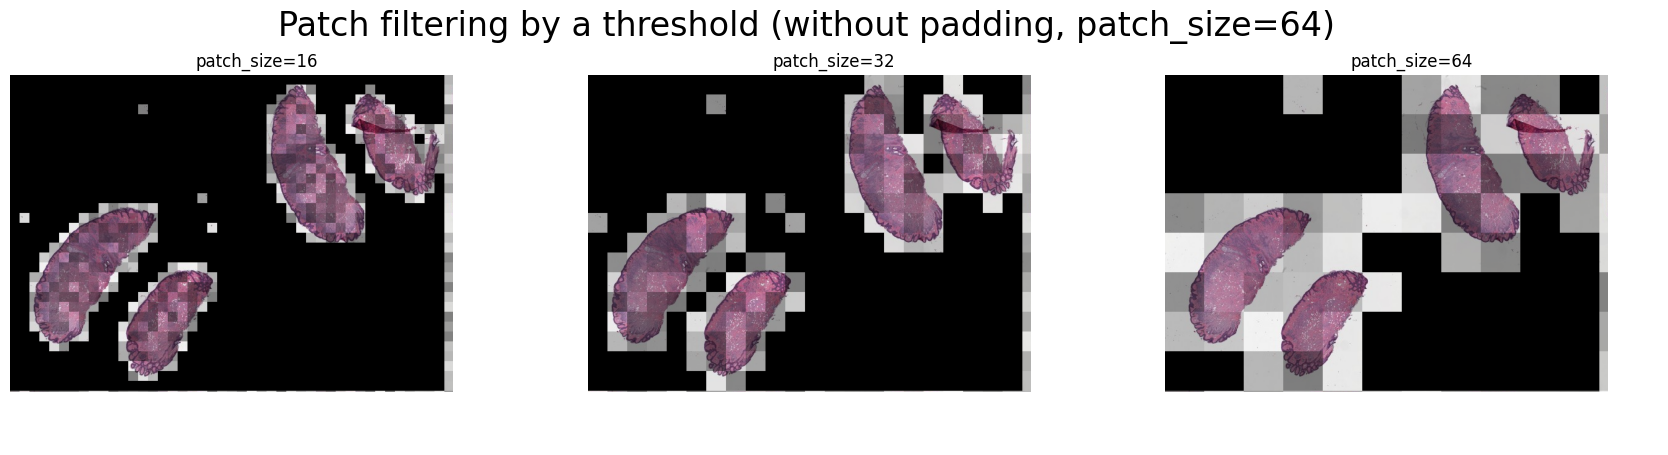

In [9]:
def filter_fn(patch, loc):
    return patch.min() < 130


patch_sizes = [16, 32, 64]
nrows = 1
ncols = len(patch_sizes)
figsize = (7 * ncols + 1, 5 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
for i, patch_size in enumerate(patch_sizes):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(
            patch_size=patch_size,
            filter_fn=filter_fn,
            reader="OpenSlide",
            level=WSI_LEVEL,
        ),
        merger_cls=AvgMerger,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"{patch_size=}", fontsize=12)

fig.suptitle(f"Patch filtering by a threshold (without padding, {patch_size=})", fontsize=24);